# Earthquake Signal Analysis

This notebook calculates the PSD of a Groningen signal at ~100m depth for project part 1



In [1]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate
from scipy.fft import rfft, rfftfreq
from scipy.signal import butter, filtfilt



In [2]:
file_path = 'NL.G192..ALL.2018-01-08.dat'

data = np.loadtxt(file_path)
    
if data.shape[1] < 4:
    raise ValueError("Expected at least 4 columns: time, Ax, Ay, Az")

time = data[:, 0]
accel_hor1 = data[:, 1]
accel_hor2 = data[:, 2]
accel_vert  = data[:, 3]




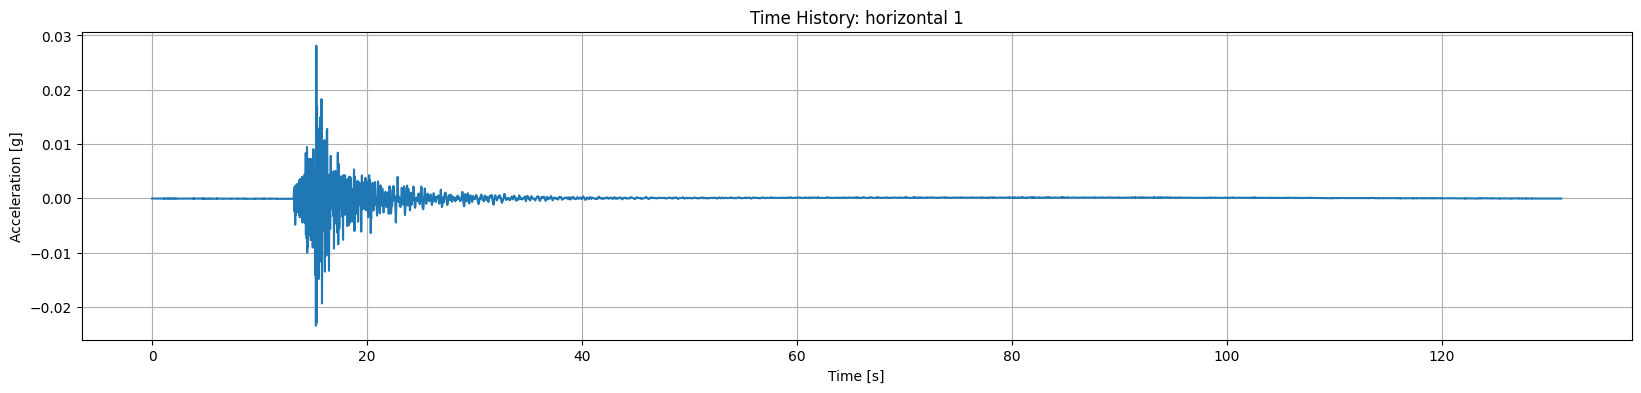

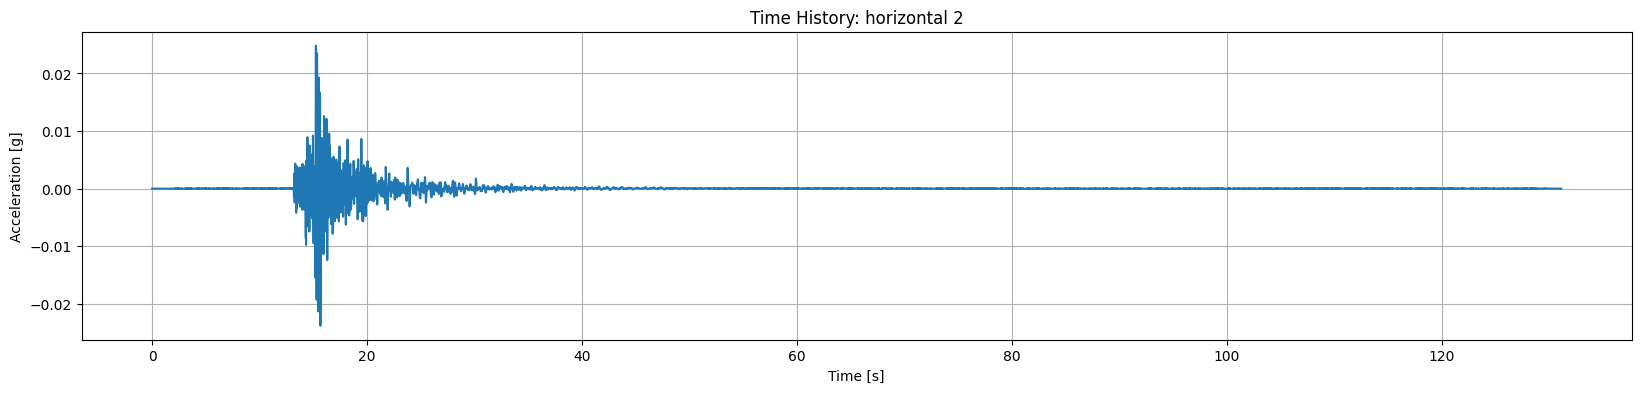

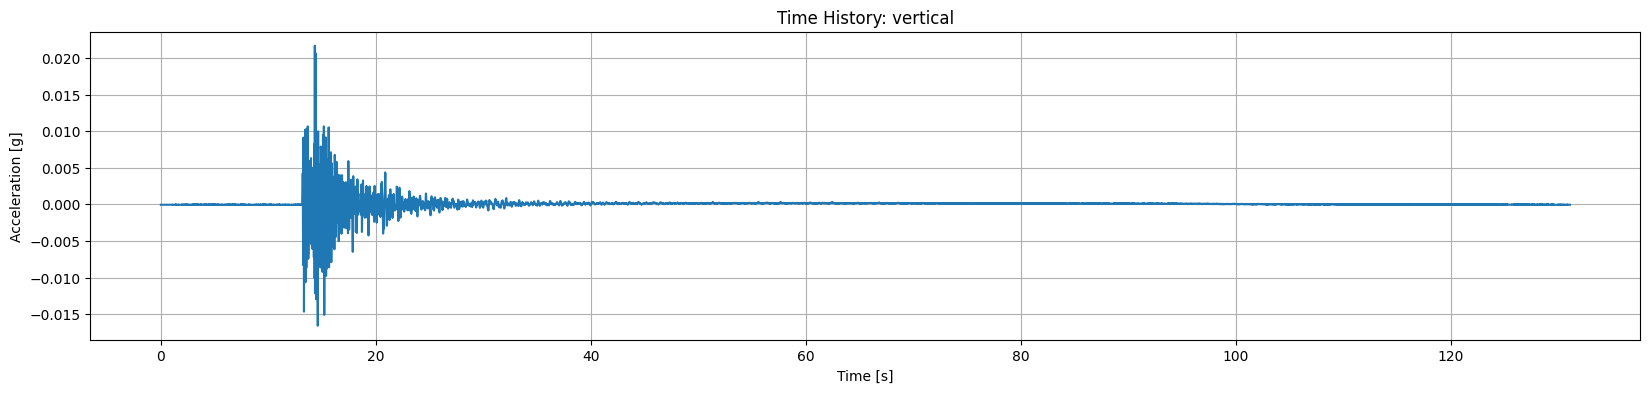

In [3]:
directions = ['horizontal 1', 'horizontal 2', 'vertical']

for accel, direction in zip([accel_hor1, accel_hor2,accel_vert], directions):
    plt.figure(figsize=(20, 4))
    plt.plot(time, accel)
    plt.title(f'Time History: {direction}')
    plt.xlabel('Time [s]')
    plt.ylabel('Acceleration [g]')
    plt.grid(True)
    plt.show()


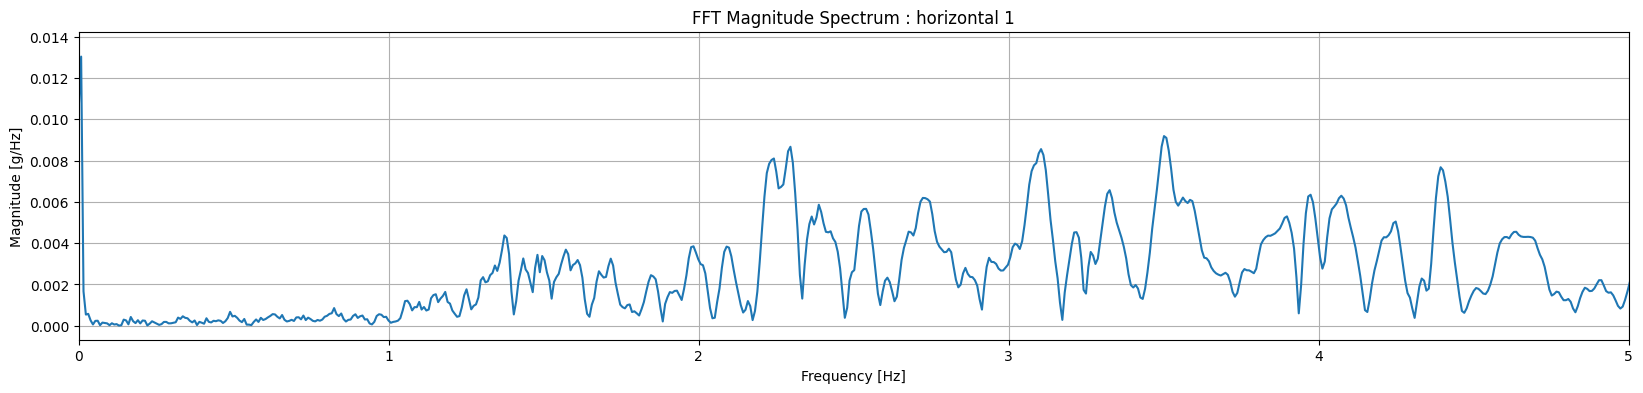

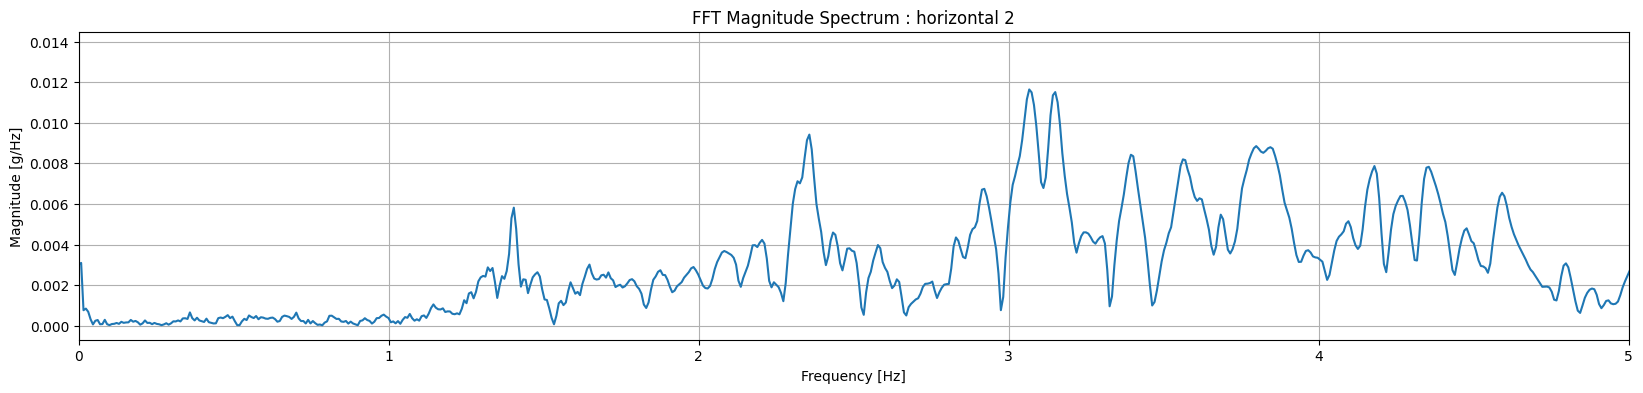

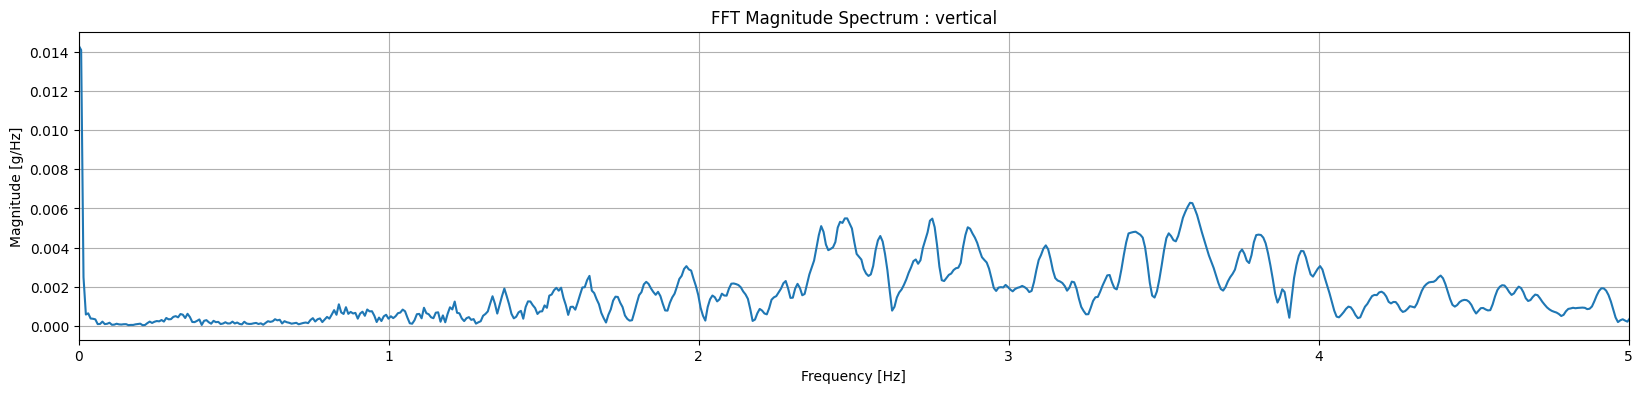

In [4]:
# perform fft
N = len(accel)
dt = time[1] - time[0]
fs = 1/dt
T = N * dt
freq = rfftfreq(N, dt)
df = freq[1]
fft_all = 3 * [None]

# get ffts
for i, accel in enumerate([accel_hor1, accel_hor2,accel_vert]):
    fft_all[i] = 2.0 * dt * rfft(accel)  # dt = 1/(N*df) - to correct for scaling to Amplitude / Hz
    

# plot ffts
for i, direction in enumerate(directions):
    plt.figure(figsize=(20, 4))
    plt.plot(freq, np.abs(fft_all[i]))
    plt.title(f'FFT Magnitude Spectrum : {direction}')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Magnitude [g/Hz]')
    plt.grid(True)
    plt.xlim(0,5)
    plt.show()




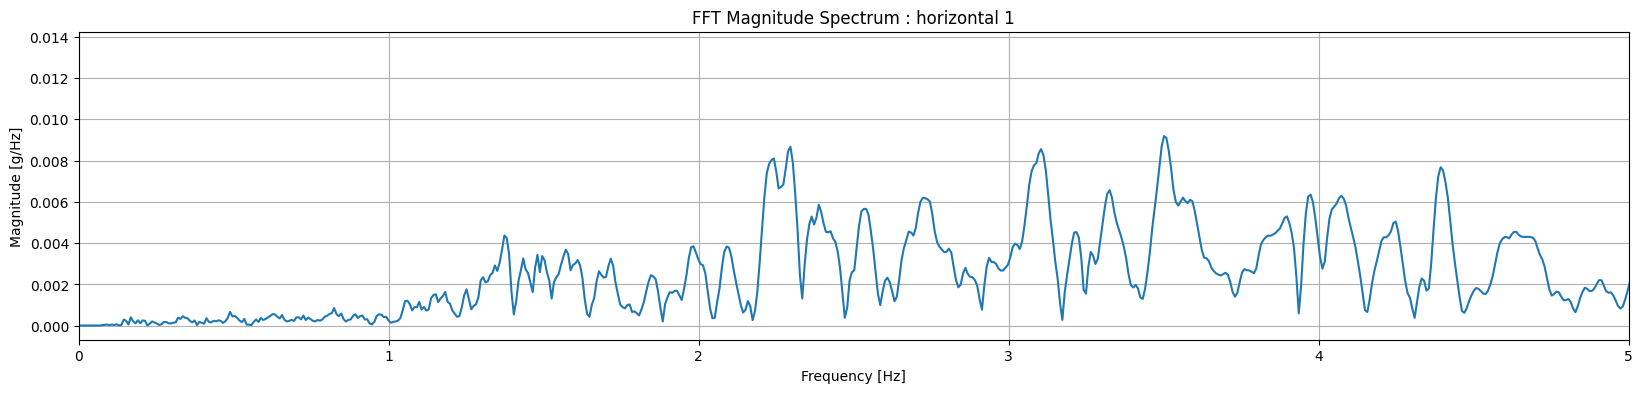

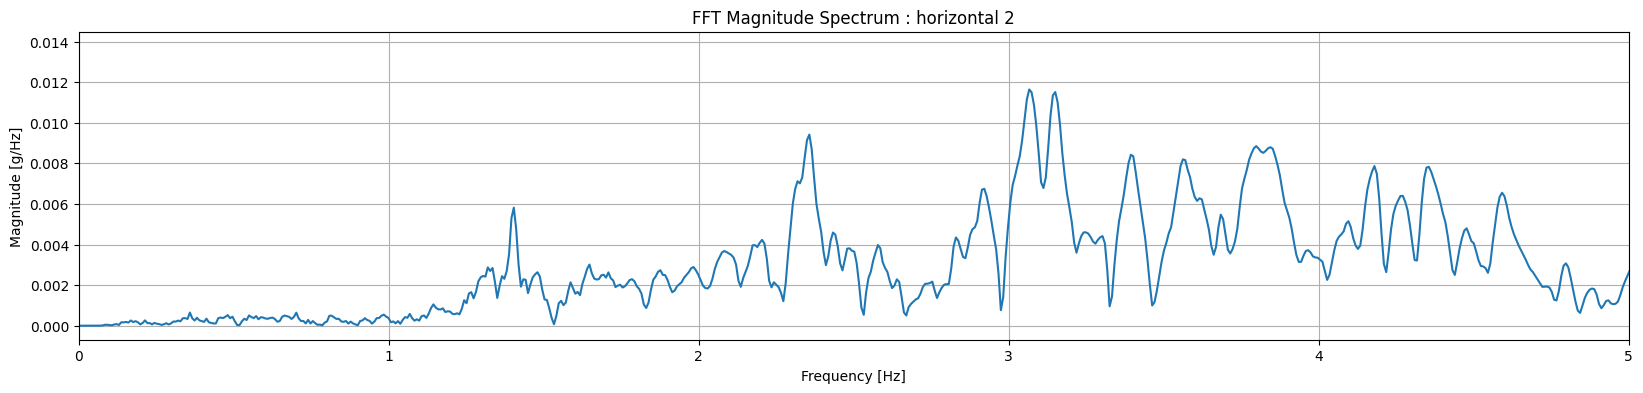

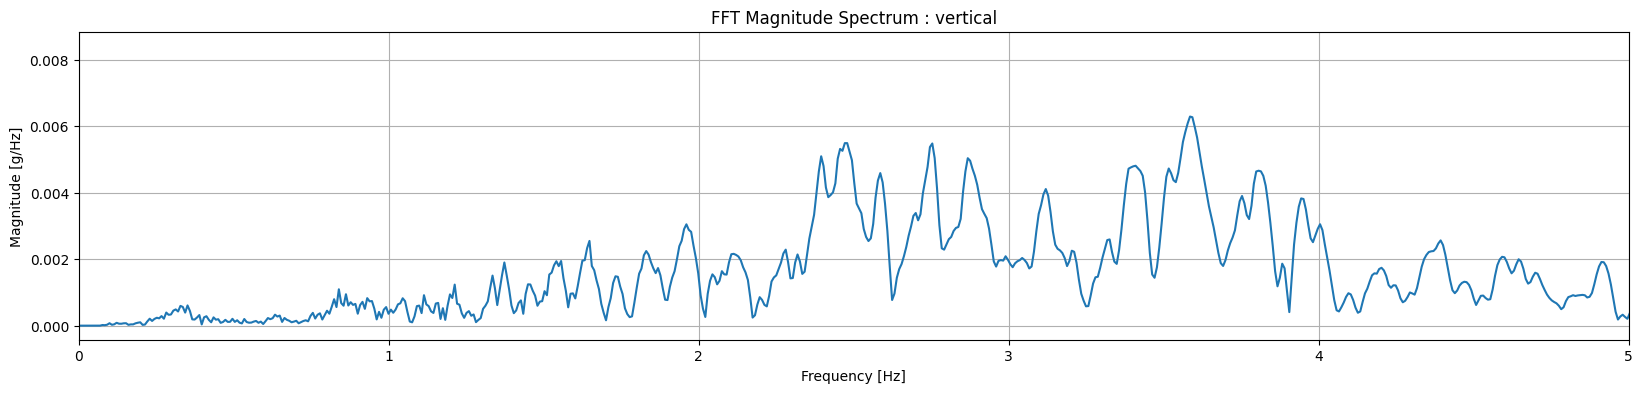

In [5]:
# Apply high-pass filter to remove low frequency oscillation
def highpass_filter(signal, fs, cutoff=0.1, order=4):
    """
    Applies a Butterworth high-pass filter to remove low-frequency oscillations.

    Parameters:
        signal (np.ndarray): The input signal (1D array).
        fs (float): Sampling frequency in Hz.
        cutoff (float): Cutoff frequency in Hz (e.g., 0.1 Hz).
        order (int): Filter order (default = 4).

    Returns:
        np.ndarray: The filtered signal.
    """
    nyq = 0.5 * fs           # Nyquist frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    filtered = filtfilt(b, a, signal)
    return filtered

accel_hor1_filtered = highpass_filter(accel_hor1, fs, cutoff=0.1)
accel_hor2_filtered = highpass_filter(accel_hor2, fs, cutoff=0.1)
accel_vert_filtered = highpass_filter(accel_vert, fs, cutoff=0.1)

# and plot again for inspection
fft_all_filtered = 3 * [None]

# get ffts
for i, accel in enumerate([accel_hor1_filtered, accel_hor2_filtered,accel_vert_filtered]):
    fft_all_filtered[i] = 2.0 * dt * rfft(accel)  # dt = 1/(N*df) - to correct for scaling to Amplitude / Hz
    

# plot ffts
for i, direction in enumerate(directions):
    plt.figure(figsize=(20, 4))
    plt.plot(freq, np.abs(fft_all_filtered[i]))
    plt.title(f'FFT Magnitude Spectrum : {direction}')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Magnitude [g/Hz]')
    plt.grid(True)
    plt.xlim(0,5)
    plt.show()

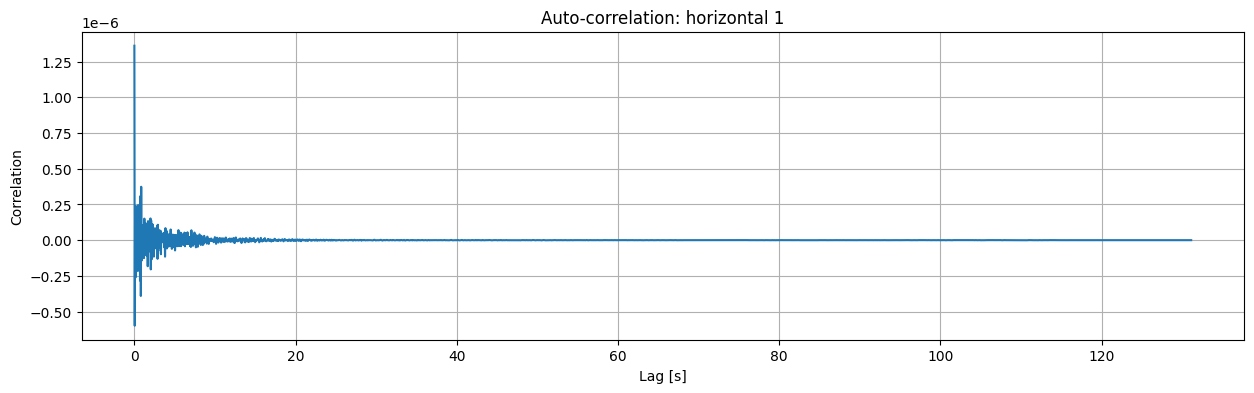

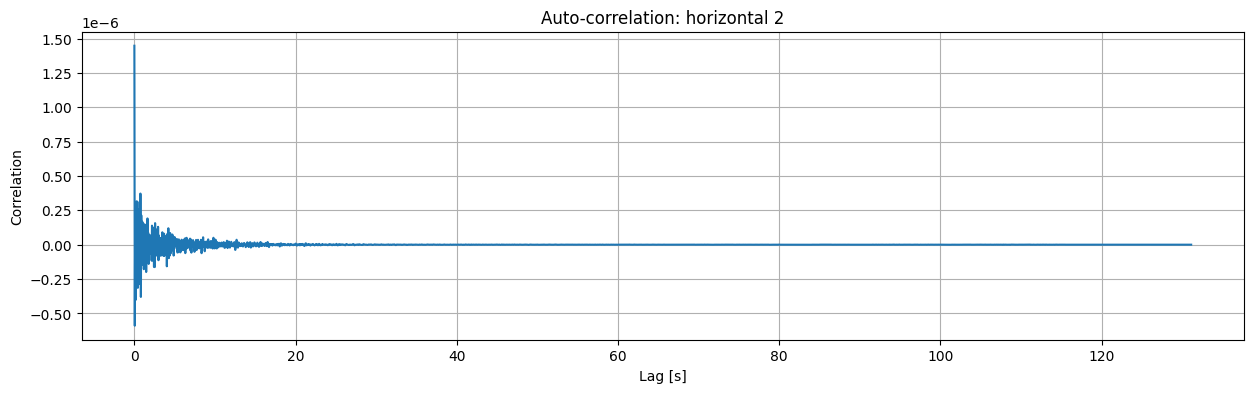

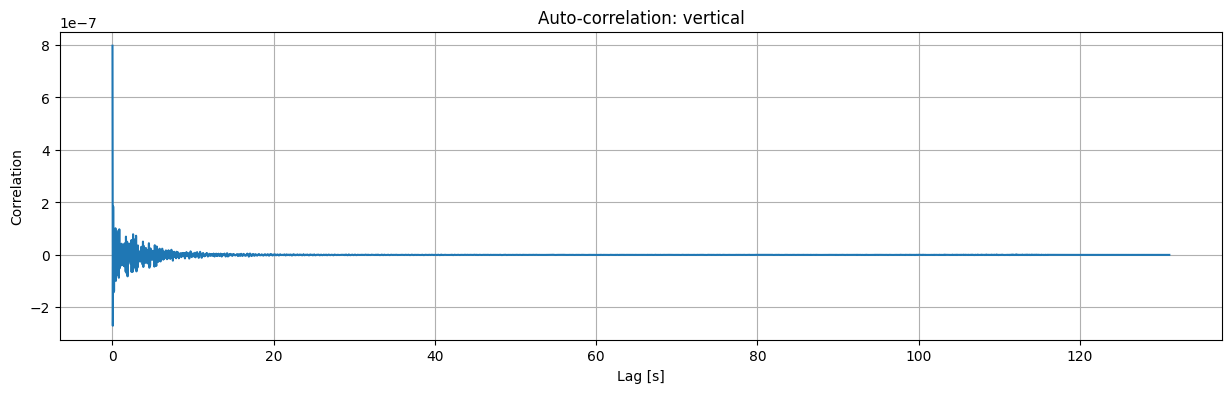

In [6]:
corr_all = 3 * [None]

# Calculate correlations
for i, accel in enumerate([accel_hor1_filtered, accel_hor2_filtered,accel_vert_filtered]):
    corr = correlate(accel, accel, mode='full') * dt # dt as the definition is the integral over time
    lags = np.arange(-len(accel) + 1, len(accel)) * dt

    # divide by total bin length
    normalization = np.array([N - abs(lag) for lag in range(-N + 1, N)]) * dt # dt here such to divide each point by total time T(tau) dependent on the finite signal (t2-t1)
    corr = corr / normalization
    corr_all[i] = [corr, lags]

    plt.figure(figsize=(15, 4))
    plt.plot(lags[(2*N-1)//2:], corr[(2*N-1)//2:])
    plt.title(f'Auto-correlation: {directions[i]}')
    plt.xlabel('Lag [s]')
    plt.ylabel('Correlation')
    plt.grid(True)
    plt.show()


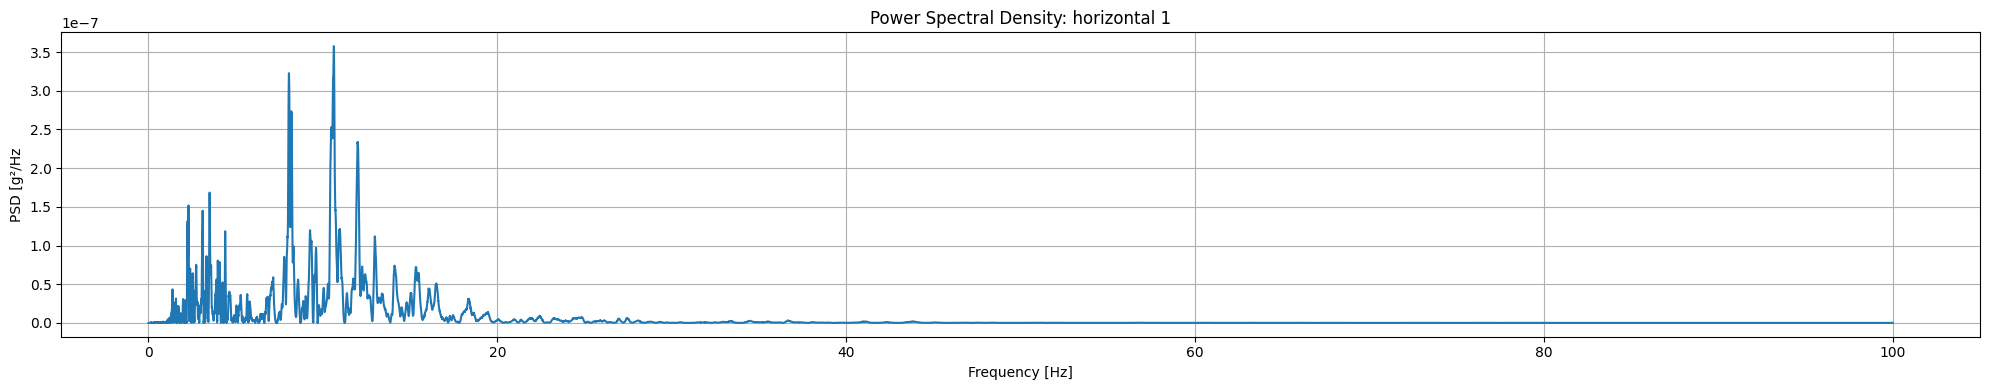

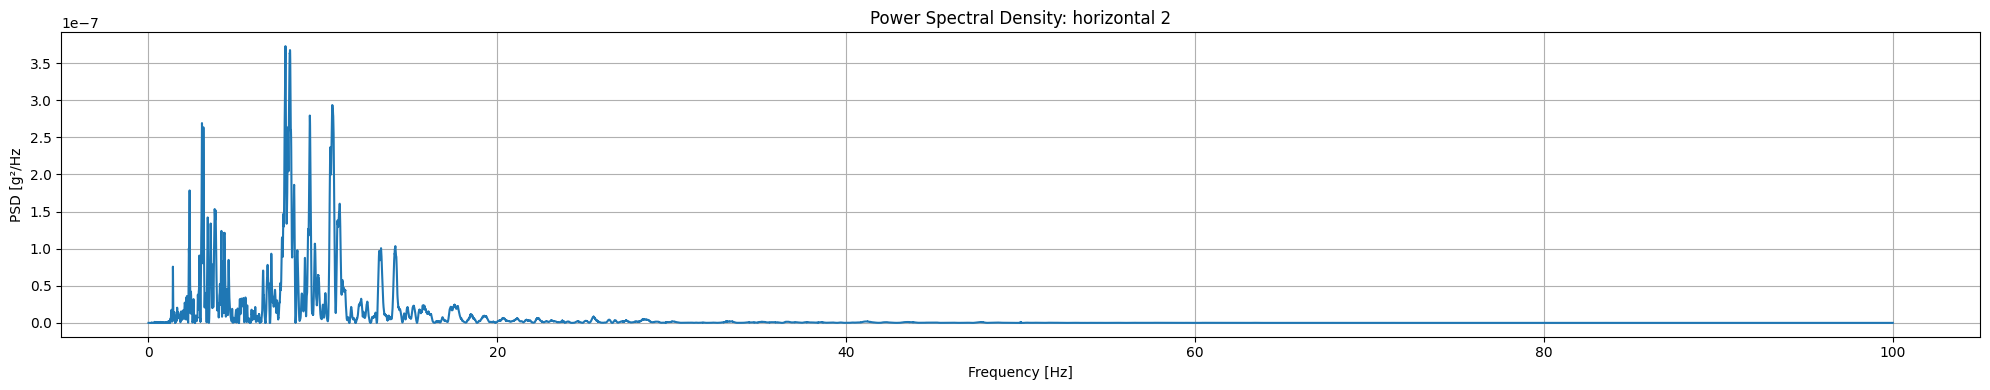

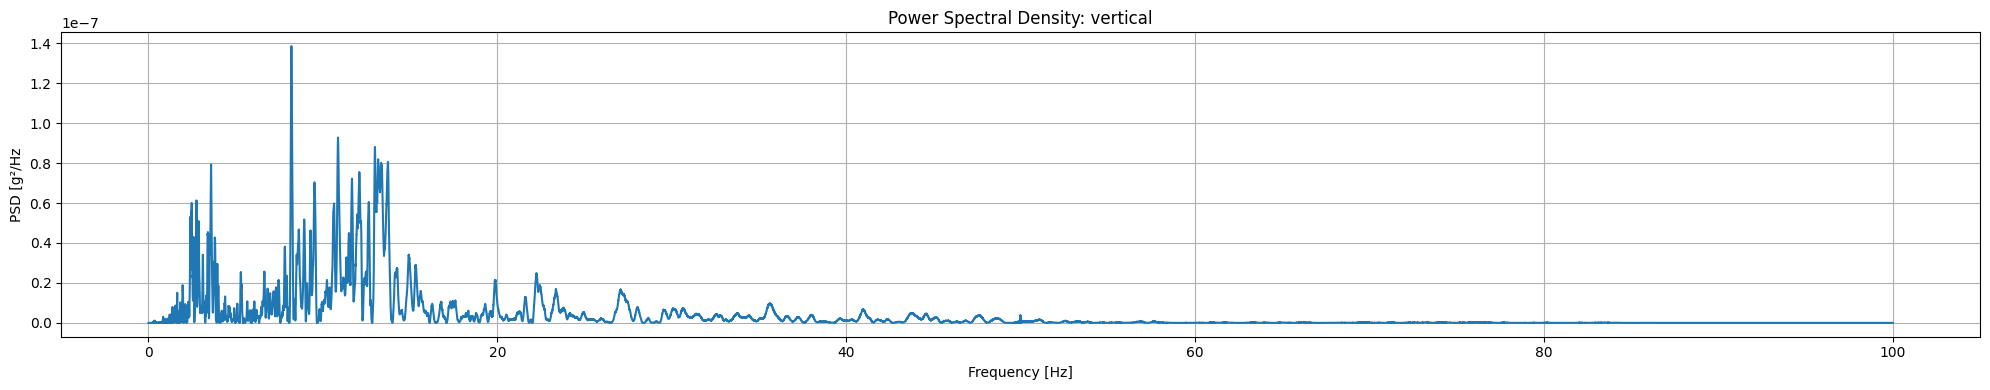

In [7]:
PSD_all = 3 * [None]
# Power Spectral Density as fourier transform of the correlation function
for i, corr_lag in enumerate(corr_all):
    corr = corr_lag[0]
    N_psd = len(corr)
    PSD = abs(rfft(corr)) * dt # no multiplication with 2 due to using negative lag as well, just dt to get /Hz
    freq_psd = rfftfreq(len(corr),dt)
    
    PSD_all = [PSD, freq_psd]
    # plot
    plt.figure(figsize=(20, 4))
    plt.plot(freq_psd, PSD)
    plt.title(f"Power Spectral Density: {directions[i]}")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("PSD [g²/Hz")
    plt.grid(True)
    # plt.xlim(0,20)
    plt.tight_layout()
    plt.show()